In [96]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import argparse
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import sys
import numpy as np
import pandas as pd

from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import History
import matplotlib.pyplot as plt
import preprocessor as p
from nltk.stem import PorterStemmer
import re

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import RBMFuncs
from importlib import reload
reload(RBMFuncs)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History
from keras.layers import Dropout
from keras import regularizers

## Importing and cleaning data
- Tokenizing the data
- Splitting into test and train set
- ** Note that the corpus needs to be converted into a word index (integer representation of the word) before splitting into test and train
- Encode as a glove vector using my RBMFuncs.encode_glove_unigram function

In [97]:
data = pd.read_csv('train_validation_set_withScores-Subset.csv' , encoding = 'utf-8')
myBool = data.dummy == 1
smalldata = data[myBool]
print(smalldata.shape)
smalldata = smalldata.sort_values(['text' , 'score'] , ascending = [0,0])
dropped = 0
for i in range(0,3453):
    previous = smalldata['text'][smalldata.index[i]]
    current = smalldata['text'][smalldata.index[i+1]]
    if current == previous:
        previous = current
        smalldata.drop(data.index[i] , inplace = True)
        dropped+=1
print(str(dropped) + "dropped")
print(smalldata.shape)
data = smalldata.append(data[data.dummy == 0])

emoDict = {'anger' : 0 , 'fear' : 1 , 'joy': 2 , 'sadness' : 3 , 'nothing' : 4}
labels = [] #initializing
for emo in data.emotion:
    labels.append(emoDict.get(emo))
    
labels = np.array(labels) #Save it as an array
    
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = data.text
texts = texts.apply(RBMFuncs.clean_text)

MAX_SEQUENCE_LENGTH = 30
VALIDATION_SPLIT = .2

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) #This is the text converted into integers

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

from keras.utils import to_categorical
#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a test set
from sklearn.model_selection import train_test_split
subsetBool = labels != 4
X_train, X_test, y_train, y_test = train_test_split(data[subsetBool], labels[subsetBool] , test_size=0.33, random_state=42)

print('Shape of train data:', X_train.shape)
print('Shape of test data:', X_test.shape)
#word_index = tokenizer.word_index

(3536, 5)
50dropped
(3486, 5)
Found 34305 unique tokens.
Shape of data tensor: (20683, 30)
Shape of label tensor: (20683,)
Shape of train data: (2335, 30)
Shape of test data: (1151, 30)


In [99]:
y_test_dummy = RBMFuncs.convertYToDummy(y_test)

In [100]:
#Note that this functions imports the glove vectors from a text file and takes a lot of time.
import time
tick = time.time()
EMBEDDING_DIM = 200
x_train_glove , x_test_glove = RBMFuncs.encode_glove_unigram(X_train , X_test , embedding_dim = EMBEDDING_DIM , word_index = word_index)
y_train_dummy = RBMFuncs.convertYToDummy(y_train)
tock = time.time()

print("It took: " + str(tock - tick) + " seconds")

Found 400000 word vectors.
Vectors not found: 16366
The dimention of the embedding Matrix should be : (nx , EMBEDDING_DIM)
And it actually is: (34306, 200)
Shape of Training set now is: (2335, 6000)
Shape of Test set now is: (1151, 6000)
It took: 34.55919003486633 seconds


## Making the Neural Network

In [101]:
UNITS = [41,44,56]
originalAlpha = 0.00271824
DROPOUT =  [0.32, 0.32, 0.29] 
add = np.random.randint(1000,9999) / 10000000
REGU = [0.0001445439770745928 , 0.0008604439770745928, 0.0001445439770745928]
model = RBMFuncs.create_Model(UNITS=UNITS , DROPOUT=DROPOUT , REGU = REGU , LEARNING_RATE = originalAlpha , INPUT_DIM = INPUT_DIM)
EPOCHS = 120
BATCH_SIZE = 256 #This is the best test accuracy 0.558530986993114
model.fit(x_train_glove, y_train_dummy , epochs = EPOCHS , batch_size = BATCH_SIZE)
acc = RBMFuncs.accuracyFunc(x_test_glove , y_test ,  model)

Compiled
Epoch 1/120
2335/2335 [==============================] - 1s 511us/step - loss: 1.4050 - acc: 0.2951
Epoch 2/120
2335/2335 [==============================] - 0s 99us/step - loss: 1.3709 - acc: 0.3058
Epoch 3/120
2335/2335 [==============================] - 0s 101us/step - loss: 1.2636 - acc: 0.3996
Epoch 4/120
2335/2335 [==============================] - 0s 99us/step - loss: 1.0630 - acc: 0.4929
Epoch 5/120
2335/2335 [==============================] - 0s 102us/step - loss: 0.9371 - acc: 0.5927
Epoch 6/120
2335/2335 [==============================] - 0s 103us/step - loss: 0.8027 - acc: 0.6719
Epoch 7/120
2335/2335 [==============================] - 0s 102us/step - loss: 0.7095 - acc: 0.7071
Epoch 8/120
2335/2335 [==============================] - 0s 101us/step - loss: 0.6368 - acc: 0.7383
Epoch 9/120
2335/2335 [==============================] - 0s 101us/step - loss: 0.5650 - acc: 0.7790
Epoch 10/120
2335/2335 [==============================] - 0s 101us/step - loss: 0.5088 - acc:

Confusion matrix, without normalization
[[158  84  24  36]
 [ 39 186  38  58]
 [ 27  29 167  38]
 [ 37  56  39 135]]


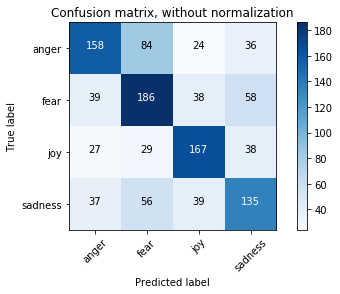

In [102]:
y_pred_test = model.predict(x_test_glove).argmax(axis = -1)
predDfTest = pd.DataFrame({'Actual' : y_test , 'Predicted' : y_pred_test})
#valDf = predDf.tail(266)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(predDfTest.Actual, predDfTest.Predicted)
np.set_printoptions(precision=2)
plt.figure()
class_names = np.array(['anger' , 'fear' ,'joy' , 'sadness'])
RBMFuncs.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [104]:
acc

0.5612510860121633

# Pre training weights using an RBM

In [637]:
#Tuning the learning rate of the RBM
#Randomly searching on Learning_rate between .001 and .01
NUM_MODELS = 1
#RBMAlpha = {}
#x = np.random.randint(100,99999999,NUM_MODELS)/10000000000
#RBMAlpha = 10 ** x
#RBMAlpha = .05 + x
#RBMAlpha = 0.02630268 #For the 300x 30 dimension thing
RBMAlpha = [.0055731875800000004] #For the new 300x 30

Creating the RBM objects are storing them in a list.
- myRBMs{} is a dictionary which stores individual sklearn RBM objects. Even though they are fitted using the Pipeline object, I have to store them in a dictionary because I need to call each object by name when returning the weights.
- piplines is a list of the sklearn Pipelines objects. I will iterate through this list when fitting.

In [638]:
#For training the RBM, I will use the entire data set
X_train_RBM, X_test_RBM, y_train_RBM, y_test_RBM = train_test_split(data, labels , test_size=0.33, random_state=42)
#Note that this functions imports the glove vectors from a text file and takes a lot of time.
import time
tick = time.time()
x_train_glove_RBM , x_test_glove_RBM = RBMFuncs.encode_glove_unigram(X_train_RBM , X_test_RBM , embedding_dim = EMBEDDING_DIM , word_index = word_index)
y_train_RBM_dummy = RBMFuncs.convertYToDummy(y_train_RBM)
tock = time.time()
print("It took: " + str(tock - tick) + " seconds")

Found 400000 word vectors.
The dimention of the embedding Matrix should be : (nx , EMBEDDING_DIM)
And it actually is: (34343, 200)
Shape of Training set now is: (13891, 6000)
Shape of Test set now is: (6842, 6000)
It took: 45.309609174728394 seconds


In [639]:
from sklearn import linear_model, datasets, metrics
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

bestArchIter1 = [41,44,56]
NUM_ITER = 20
myRBMs = {}
pipelines = []
foo = 0
for i in range(NUM_MODELS):
    foo+=1
    myRBMs["rbm1_"+str(i+1)] = BernoulliRBM(random_state=0, verbose=True)
    myRBMs["rbm1_"+str(i+1)].learning_rate = RBMAlpha[i]
    myRBMs["rbm1_"+str(i+1)].n_components = bestArchIter1[0]
    
    myRBMs["rbm2_"+str(i+1)] = BernoulliRBM(random_state=0, verbose=True)
    myRBMs["rbm2_"+str(i+1)].learning_rate = RBMAlpha[i]
    myRBMs["rbm2_"+str(i+1)].n_components = bestArchIter1[1]
    
    myRBMs["rbm3_"+str(i+1)] = BernoulliRBM(random_state=0, verbose=True)
    myRBMs["rbm3_"+str(i+1)].learning_rate = RBMAlpha[i]
    myRBMs["rbm3_"+str(i+1)].n_components = bestArchIter1[2]
    
    tempPipeline = Pipeline(steps=[('rbm1_'+str(i+1), myRBMs["rbm1_"+str(i+1)]) , ('rbm2_'+str(i+1), myRBMs["rbm2_"+str(i+1)]) , ('rbm3_'+str(i+1), myRBMs["rbm3_"+str(i+1)])])
    pipelines.append(tempPipeline)

print(str(foo) + " models in total")

for i in range(NUM_MODELS):
    pipelines[i].fit(x_train_glove_RBM)

1 models in total
[BernoulliRBM] Iteration 1, pseudo-likelihood = -3101.14, time = 19.54s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3310.58, time = 20.26s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3733.78, time = 19.68s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -4366.91, time = 20.06s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -5002.59, time = 19.77s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -5656.63, time = 19.68s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -6319.06, time = 20.03s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -6977.34, time = 19.75s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -7639.15, time = 19.69s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -8301.91, time = 20.14s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -2.49, time = 0.27s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2.37, time = 0.35s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2.40, time = 0.35s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2.42, ti

In [503]:
# Setting up the ANN models whose weights will be initalized by the weights of theRBM

In [640]:
import keras
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
import random
from keras import regularizers
preTrainedModels = []
multiplier = .001
for i in range(NUM_MODELS):
    def rbm1_init(shape ,dtype=None):
        return myRBMs["rbm1_"+str(i+1)].components_.T * multiplier

    def rbm2_init(shape ,dtype=None):
        return myRBMs["rbm2_"+str(i+1)].components_.T * multiplier
    
    def rbm3_init(shape ,dtype=None):
        return myRBMs["rbm3_"+str(i+1)].components_.T * multiplier
    

    preTrainedClassifer = Sequential()
    preTrainedClassifer.add(Dense(units = UNITS[0], kernel_initializer = rbm1_init , activation = 'relu', input_dim = INPUT_DIM,
                                 kernel_regularizer=regularizers.l2(REGU[0])))
    preTrainedClassifer.add(Dropout(DROPOUT[0]))

    preTrainedClassifer.add(Dense(units = UNITS[1], kernel_initializer = rbm2_init , activation = 'relu' ,
                                  kernel_regularizer=regularizers.l2(REGU[1])))
    preTrainedClassifer.add(Dropout(DROPOUT[1]))

    preTrainedClassifer.add(Dense(units = UNITS[2], kernel_initializer = rbm3_init , activation = 'relu', 
                                 kernel_regularizer=regularizers.l2(REGU[2])))
    preTrainedClassifer.add(Dropout(DROPOUT[2]))

    preTrainedClassifer.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    #EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
    #checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    #EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
    myAdam = keras.optimizers.Adam(lr= originalAlpha, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    preTrainedClassifer.compile(optimizer = myAdam , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    preTrainedModels.append(preTrainedClassifer)

In [641]:
#VALIDATION_SPLIT = .5
print("Fitting model...")
modelHistory = []
EPOCHS = 100
for i in range(NUM_MODELS):
    histTemp = preTrainedModels[i].fit(x_train_glove, y_train_dummy, epochs = EPOCHS, batch_size = BATCH_SIZE , shuffle = True)
    modelHistory.append(histTemp)

Fitting model...
Epoch 1/100
2369/2369 [==============================] - 14s 6ms/step - loss: 1.3854 - acc: 0.2697
Epoch 2/100
2369/2369 [==============================] - 0s 163us/step - loss: 1.3532 - acc: 0.2913
Epoch 3/100
2369/2369 [==============================] - 0s 152us/step - loss: 1.2498 - acc: 0.2896
Epoch 4/100
2369/2369 [==============================] - 0s 166us/step - loss: 1.1776 - acc: 0.4238
Epoch 5/100
2369/2369 [==============================] - 0s 151us/step - loss: 1.1382 - acc: 0.4597
Epoch 6/100
2369/2369 [==============================] - 0s 164us/step - loss: 1.0922 - acc: 0.4918
Epoch 7/100
2369/2369 [==============================] - 0s 162us/step - loss: 1.0432 - acc: 0.5103
Epoch 8/100
2369/2369 [==============================] - 0s 163us/step - loss: 1.0151 - acc: 0.5087
Epoch 9/100
2369/2369 [==============================] - 0s 161us/step - loss: 0.9745 - acc: 0.5184
Epoch 10/100
2369/2369 [==============================] - 0s 166us/step - loss: 0.94

2369/2369 [==============================] - 0s 157us/step - loss: 0.2763 - acc: 0.9574
Epoch 83/100
2369/2369 [==============================] - 0s 155us/step - loss: 0.2809 - acc: 0.9603
Epoch 84/100
2369/2369 [==============================] - 0s 158us/step - loss: 0.2819 - acc: 0.9574
Epoch 85/100
2369/2369 [==============================] - 0s 158us/step - loss: 0.2528 - acc: 0.9683
Epoch 86/100
2369/2369 [==============================] - 0s 155us/step - loss: 0.2729 - acc: 0.9595
Epoch 87/100
2369/2369 [==============================] - 0s 155us/step - loss: 0.2658 - acc: 0.9599
Epoch 88/100
2369/2369 [==============================] - 0s 157us/step - loss: 0.2794 - acc: 0.9624
Epoch 89/100
2369/2369 [==============================] - 0s 154us/step - loss: 0.2631 - acc: 0.9599
Epoch 90/100
2369/2369 [==============================] - 0s 156us/step - loss: 0.2659 - acc: 0.9603
Epoch 91/100
2369/2369 [==============================] - 0s 157us/step - loss: 0.2820 - acc: 0.9574
Epo

**The high validation accuracy issue**

How is the validation split computed?
If you set the validation_split argument in model.fit to e.g. 0.1, then the validation data used will be the last 10% of the data. If you set it to 0.25, it will be the last 25% of the data, etc. Note that the data isn't shuffled before extracting the validation split, **so the validation is literally just the last x% of samples in the input you passed.**

**The same validation set is used for all epochs (within a same call to fit).**

Is the data shuffled during training?
Yes, if the shuffle argument in model.fit is set to True (which is the default), the training data will be randomly shuffled at each epoch.

**Validation data is never shuffled.**

Text(0.5,1,'Validation curve')

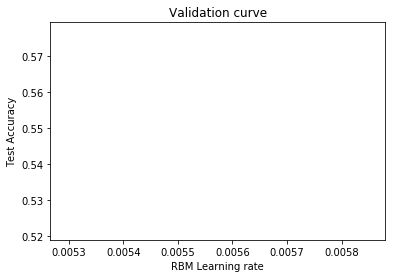

In [642]:
trainAcc = []
testAcc = []
for i in range(NUM_MODELS):
    trainAcc.append(modelHistory[i].history['acc'][-1])
    testAcc.append(RBMFuncs.accuracyFunc(x_test_glove , y_test , preTrainedModels[i]))
    
#plt.plot(np.sort(RBMAlpha) , np.array(trainAcc)[np.argsort(RBMAlpha)])
plt.plot(np.sort(np.array(RBMAlpha)) , np.array(testAcc)[np.argsort(RBMAlpha)])
plt.ylabel("Test Accuracy")
plt.xlabel("RBM Learning rate")
plt.title("Validation curve")

In [643]:
testAcc

[0.5492716366752356]

Confusion matrix, without normalization
[[133  67  11  82]
 [ 72 173   6 107]
 [ 33  20 110 101]
 [ 47  56  21 128]]


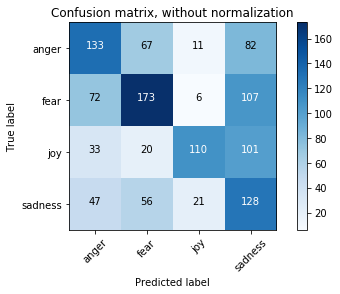

In [627]:
y_pred_test = preTrainedModels[0].predict(x_test_glove).argmax(axis = -1)
predDfTest = pd.DataFrame({'Actual' : y_test , 'Predicted' : y_pred_test})
#valDf = predDf.tail(266)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(predDfTest.Actual, predDfTest.Predicted)
np.set_printoptions(precision=2)
plt.figure()
class_names = np.array(['anger' , 'fear' ,'joy' , 'sadness'])
RBMFuncs.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')